# Market Basket Analysis

In [ ]:
#Importazione delle librerie e definizione dei plot
import pandas as pd
import numpy as np
import re
from scipy import stats
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
import datetime
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx

In [ ]:
from importlib_metadata import version
print("Versione libreria pandas: " + version('pandas'))
print("Versione libreria numpy: " + version('numpy'))
print("Versione libreria re: " + version('regex'))
print("Versione libreria scipy: " + version('scipy'))
print("Versione libreria matplotlib: " + version('matplotlib'))
print("Versione libreria seaborn: " + version('seaborn'))
print("Versione libreria mlxtend: " + version('mlxtend'))
print("Versione libreria networkx: " + version('networkx'))

Versione libreria pandas: 1.3.5
Versione libreria numpy: 1.21.6
Versione libreria re: 2022.6.2
Versione libreria scipy: 1.7.3
Versione libreria matplotlib: 3.2.2
Versione libreria seaborn: 0.11.2
Versione libreria mlxtend: 0.14.0
Versione libreria networkx: 2.6.3


In [ ]:
#Accesso a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importazione dei dataset
BASE_PATH = '/content/drive/MyDrive/Progetto_Web/Dataset_Clean/'
df7 = pd.read_csv(BASE_PATH + 'df7.csv', sep = ',', na_values = '', encoding = 'latin-1')

## Data Preparation

In [ ]:
#Formattazione dei tipi delle colonne
df7['DATETIME'] = pd.to_datetime(df7['DATETIME'])
df7['DATA'] = pd.to_datetime(df7['DATA'])
df7 = df7.astype({'DIREZIONE': 'category'})
df7 = df7.astype({'COD_REPARTO': 'category'})

## Data Processing for MBA

In [ ]:
#Considero solo gli acquisti (DIREZIONE = 1)
df7_mba = df7.drop(df7.index[df7['DIREZIONE'] == -1])
#Elimino colonna DIREZIONE perché non mi serve più a nulla
df7_mba.drop(columns = ['DIREZIONE'], inplace = True)
df7_mba.reset_index(drop = True, inplace = True)

In [ ]:
#Controllo se ci sono righe con IMPORTO_NETTO < 0 perché interessano solo gli acquisti e nel caso le elimino
df7_mba.drop(df7_mba.index[df7_mba['IMPORTO_NETTO'] < 0], inplace = True)
df7_mba.reset_index(drop = True, inplace = True)

In [ ]:
#Per questioni di dimensioni del dataset e per coerenza con quello fatto per RFM considero gli acquisti dal 25-02-2019 in poi
df7_mba.drop(df7_mba.index[df7_mba['DATA'] < '2019-02-19'], inplace = True)
df7_mba.reset_index(inplace = True, drop = True)

## Data Overview for MBA

In [ ]:
#Alcune variabili utili
num_scontrini = df7_mba['ID_SCONTRINO'].nunique() #numero di scontrini diversi
num_articoli = df7_mba['ID_ARTICOLO'].nunique() #numero di articoli diversi
print(f'Numero di scontrini diversi = {num_scontrini}')
print(f'Numero di articoli diversi = {num_articoli}')

Numero di scontrini diversi = 188938
Numero di articoli diversi = 62582


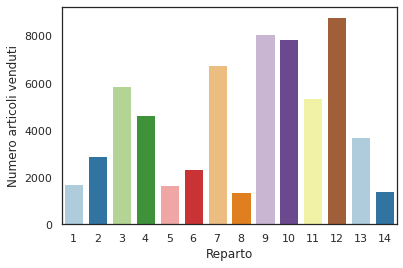

In [ ]:
#Distribuzione dei diversi articoli in base al reparto di appartenenza, all'importo medio e alla percentuale di scontrini diversi
prodotti = df7_mba.groupby(['ID_ARTICOLO', 'COD_REPARTO']).agg(IMPORTO_MEDIO = ('IMPORTO_NETTO', 'mean'), PERC_SCONTRINI = ('ID_SCONTRINO', 'nunique'))
prodotti.reset_index(inplace = True)
prodotti.rename(columns = {'COD_REPARTO' : 'REPARTO'}, inplace = True)
prodotti['PERC_SCONTRINI'] = (prodotti['PERC_SCONTRINI'] / num_scontrini)
prodotti.dropna(inplace = True)
prodotti.reset_index(inplace = True, drop = True)

#Barplot della distribuzione degli articoli in base al dipartimento
ax = sns.countplot(data = prodotti, x = 'REPARTO', palette = 'Paired', alpha = 1)
plt.ylabel('Numero articoli venduti', fontsize = 12)
plt.xlabel('Reparto', fontsize = 12)
plt.savefig('articoli_per_dipartimento.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

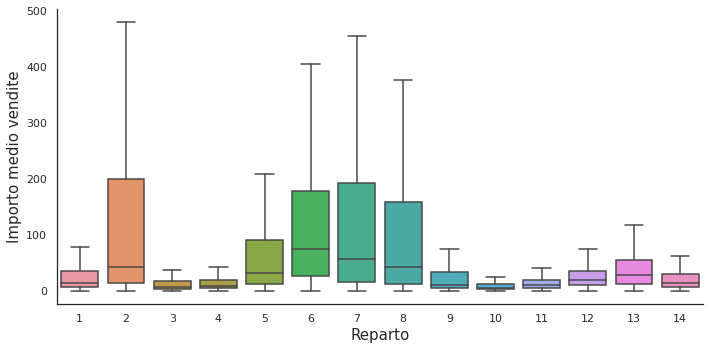

In [ ]:
#Boxplot della distribuzione degli importi medi degli articoli venduti per ogni reparto
ax = sns.catplot(data = prodotti, x = 'REPARTO', y = 'IMPORTO_MEDIO', showfliers = False, aspect = 2, kind = 'box')
plt.ylabel('Importo medio vendite', fontsize = 15)
plt.xlabel('Reparto', fontsize = 15)
plt.savefig('importo_medio_reparto.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

## Support computation

In [ ]:
#Viene creato un nuovo dataframe con la colonna CONTEGGIO che contiene la percentuale di diversi scontrini venduti per articolo
supp = df7_mba.groupby('ID_ARTICOLO', as_index = False).agg(CONTEGGIO = ('ID_SCONTRINO', 'nunique'))
supp['CONTEGGIO'] = supp['CONTEGGIO'] / num_scontrini
supp.sort_values(by = 'CONTEGGIO', ascending = False, inplace = True) #Dalla prima riga ho i valori di CONTEGGIO maggiori
supp.reset_index(inplace = True, drop = True)

In [ ]:
#Viene calcolato il supporto dei vari articoli
print(f"Articoli con supporto maggiore del 1% = {len(supp[supp['CONTEGGIO'] > 0.01])}")
print(f"Articoli con supporto compreso tra 0.1% e 1% = {len(supp[(supp['CONTEGGIO'] <= 0.01) & (supp['CONTEGGIO'] > 0.001)])}")
print(f"Articoli con supporto compreso tra 0.01% e 0.1% = {len(supp[(supp['CONTEGGIO'] <= 0.001) & (supp['CONTEGGIO'] > 0.0001)])}")
print(f"Articoli con supporto compreso tra 0.001% e 0.01% = {len(supp[(supp['CONTEGGIO'] <= 0.0001) & (supp['CONTEGGIO'] > 0.00001)])}")
print(f"Articoli con supporto compreso tra 0.0001% e 0.001% = {len(supp[(supp['CONTEGGIO'] <= 0.00001) & (supp['CONTEGGIO'] > 0.000001)])}")
print(f"Articoli con supporto minore del 0.0001% = {len(supp[supp['CONTEGGIO'] <= 0.000001])}")

Articoli con supporto maggiore del 1% = 3
Articoli con supporto compreso tra 0.1% e 1% = 309
Articoli con supporto compreso tra 0.01% e 0.1% = 8846
Articoli con supporto compreso tra 0.001% e 0.01% = 37955
Articoli con supporto compreso tra 0.0001% e 0.001% = 15469
Articoli con supporto minore del 0.0001% = 0


Text(0.5, 8.95999999999998, 'Numero di articoli')

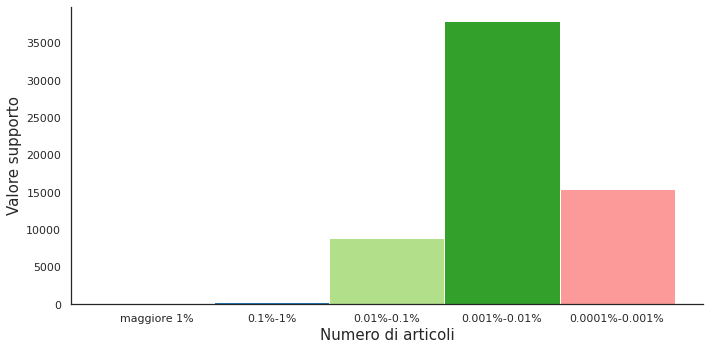

In [ ]:
#Istruzioni per rappresentare i vari supporti
condizioni = [(supp['CONTEGGIO'] > 0.01), ((supp['CONTEGGIO'] <= 0.01) & (supp['CONTEGGIO'] > 0.001)),
              ((supp['CONTEGGIO'] <= 0.001) & (supp['CONTEGGIO'] > 0.0001)), ((supp['CONTEGGIO'] <= 0.0001) & (supp['CONTEGGIO'] > 0.00001)),
              ((supp['CONTEGGIO'] <= 0.00001) & (supp['CONTEGGIO'] > 0.000001)), (supp['CONTEGGIO'] <= 0.000001)]
valori = ['maggiore 1%', '0.1%-1%', '0.01%-0.1%', '0.001%-0.01%', '0.0001%-0.001%', 'minore 0.0001%']
supp['SUPPORTO'] = np.select(condizioni, valori)

#Barplot dei supporti degli articoli
ax = sns.displot(data = supp, x = 'SUPPORTO', palette = 'Paired', alpha = 1, aspect = 2, hue = 'SUPPORTO', legend = False)
plt.ylabel('Valore supporto', fontsize = 15)
plt.xlabel('Numero di articoli', fontsize = 15)

In [ ]:
#Vengono selezionati i prodotti con alti valori di supporto (>0.1%) perché gli articoli con supporto minore, anche se sono la maggior
#parte, rappresentano un numero di articoli troppo basso
supp_high = supp[supp['CONTEGGIO'] > 0.001]
high_support = df7_mba[df7_mba['ID_ARTICOLO'].isin(supp_high['ID_ARTICOLO'])]
num_scontrini_high = high_support['ID_SCONTRINO'].nunique() #numero degli scontrini con prodotti con alto supporto

#Non ha senso tenere l'intero scontrino che contiene questi articoli perché tanto le associazioni rilevanti esistono tra
#gli articoli con alto supporto

## Overview of high support articles

In [ ]:
#Distribuzione articoli con alto supporto per reparto, importo medio e percentuale di scontrini
high_support_products = high_support.groupby(['ID_ARTICOLO', 'COD_REPARTO']).agg(IMPORTO_MEDIO = ('IMPORTO_NETTO', 'mean'), PERC_SCONTRINI = ('ID_SCONTRINO', 'nunique'))
high_support_products.reset_index(inplace = True)
high_support_products.rename(columns = {'COD_REPARTO' : 'REPARTO'}, inplace = True)
high_support_products['PERC_SCONTRINI'] = (high_support_products['PERC_SCONTRINI'] / num_scontrini)
high_support_products.dropna(inplace = True)
high_support_products.reset_index(inplace = True, drop = True)

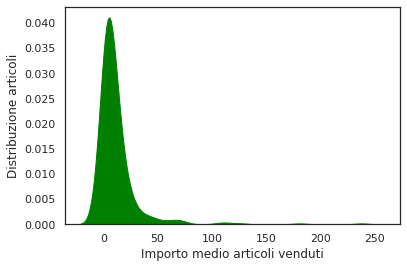

In [ ]:
#Importo medio degli articoli venduti ad alto supporto
ax = sns.kdeplot(data = high_support_products, x = 'IMPORTO_MEDIO', color = 'green', alpha = 1, fill = True)
plt.ylabel('Distribuzione articoli', fontsize = 12)
plt.xlabel('Importo medio articoli venduti', fontsize = 12)
plt.savefig('importo_medio_alto_supporto.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

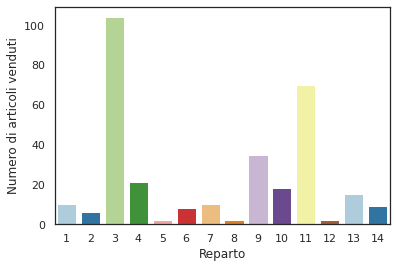

In [ ]:
#Distribuzione degli articoli con alto supporto in base al reparto di appartenenza
ax = sns.countplot(data = high_support_products, x = 'REPARTO', palette = 'Paired', alpha = 1)
plt.ylabel('Numero di articoli venduti', fontsize = 12)
plt.xlabel('Reparto', fontsize = 12)
plt.savefig('articoli_alto_supporto_per_reparto.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

#Appartengono per la maggior parte al reparto 3 e 11

## Creazione del basket

In [ ]:
#Raggruppo i dati per ID_SCONTRINO e per ID_ARTICOLO e calcolo la quantità di oggetti venduti dello stesso tipo 
#nei diversi scontrini.
quantità = high_support.groupby(['ID_SCONTRINO', 'ID_ARTICOLO'])[['ID_ARTICOLO']].count()
quantità.rename(columns = {'ID_ARTICOLO' : 'QUANTITÀ'}, inplace = True)
quantità.reset_index(inplace = True)

In [ ]:
#Qui viene creato effettivamente il basket
#Ogni riga corrisponde ad uno scontrino e le colonne, una per ogni articolo, dicono se lo scontrino contiene quel particolare
#articolo
basket = (quantità.groupby(['ID_SCONTRINO', 'ID_ARTICOLO'])['QUANTITÀ'].sum().unstack().reset_index().fillna(0).set_index('ID_SCONTRINO'))
basket.head()

ID_ARTICOLO,30097291,30126306,30329621,30329663,30344384,30410366,30410765,30475165,30482683,31002643,...,81270704,81273175,81274743,81274749,81983686,82019008,82029522,82042962,82042965,82042968
ID_SCONTRINO,,,,,,,,,,,,,,,,,,,,,
511010492122/02/19855579200582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
511010554002/03/191345489588998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
511010557802/03/191850319546129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
511010607511/03/19800382844758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
511010644716/03/19744572844758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Vengono aggiunte le righe (tutte nulle) relative agli scontrini che non contengono i prodotti ad alto supporto per un corretto risultato
low_support = pd.DataFrame(0, index=np.arange(num_scontrini-num_scontrini_high), columns = basket.columns)
basket = basket.append(low_support, ignore_index=True)

In [ ]:
#Funzione per la codifica dei dati
def encode_units(x):
  if x <= 0:
    return 0
  if x >= 1:
    return 1

In [ ]:
#Codifica dei dati
basket_encode = basket.applymap(encode_units)
#È un controllo del basket perché deve essere binario

## Apriori algorithm

In [ ]:
#Si sceglie di considerare rilevanti gli itemsets con supporto > 0.1%
#Con una percentuale superiore si otterebbero solamente tre itemsets di lunghezza pari a 1 (un solo articolo)
#Gli itemsets vengono ordinati in basi al valore di supporto
frequent_itemsets = apriori(basket_encode, min_support=0.001, use_colnames=True).sort_values('support', ascending = False).reset_index(drop = True)
frequent_itemsets['lunghezza'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets
#Ci sono 390 itemsets rilevanti

,support,itemsets,lunghezza
0,0.061295,(33700716),1
1,0.026660,(33817091),1
2,0.013825,(34843564),1
3,0.009522,(33120913),1
4,0.006844,(32882024),1
...,...,...,...
385,0.001011,"(31618321, 31618300, 31618405)",3
386,0.001011,(36323714),1
387,0.001006,(36500611),1
388,0.001006,"(31047464, 31047415)",2


## Association rules

In [ ]:
#Si implementano le regole di associazione, usando come metrica una confidenza minima di 0.65
rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = 0.65)
#Si fa pruning scegliendo un minimo valore di confidenza

In [ ]:
print(f'Numero associazioni rilevanti = {len(rules)}')
print(f"Valori di lift >= 1 = {len(rules[rules['lift'] >= 1])}")
#I valori di lift sono già tutti >= 1 quindi sono tutte associazioni rilevanti (correlazione positiva)

Numero associazioni rilevanti = 66
Valori di lift >= 1 = 66


## Deletion of redundant association rules

In [ ]:
#Non ci sono regole con lo stesso conseguente e diversi valori di confidenza
#Per quanto riguarda quelle con stesso conseguente ma confidenza diversa non è importante eliminarle perché si può ordinare
#i risultati in base alla confidenza
rules[rules.duplicated(subset = ['consequents', 'confidence'])]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


## Analysis of the results

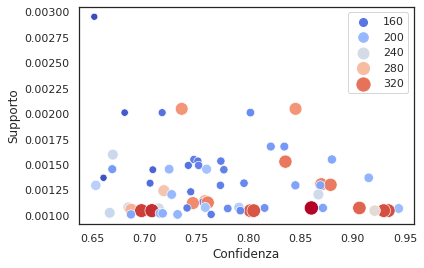

In [ ]:
# Scatterpolot delle regole
sns.scatterplot(x = "confidence", y = "support", size = "lift", data = rules, sizes=(50, 200), hue = 'lift', palette = "coolwarm")
plt.legend(markerscale = 1)
plt.ylabel('Supporto', fontsize = 12)
plt.xlabel('Confidenza', fontsize = 12)
plt.savefig('scatterplot.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

#I due pallini scuri in alto al centro hanno un buon valore di lift e confidenza e anche di supporto

In [ ]:
rules[(rules['support'] > 0.002) & (rules['lift'] >= 280)]
#Sono i due pallini interessanti

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(36298353),(36298381),0.002784,0.002424,0.002048,0.735741,303.514229,0.002042,3.775000
2,(36298381),(36298353),0.002424,0.002784,0.002048,0.844978,303.514229,0.002042,6.432746


In [ ]:
#Si selezionano le 15 regole con lift maggiore
rules_relevant = rules.sort_values(by = 'lift', ascending = False)
rules_relevant.reset_index(inplace = True, drop = True)
rules_relevant = rules_relevant.iloc[0:15]
rules_relevant

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(36298353, 36298122)",(36298381),0.001249,0.002424,0.001074,0.860169,354.844331,0.001071,7.134179
1,(36298395),"(36298353, 36298381)",0.001482,0.002048,0.001048,0.707143,345.235548,0.001045,3.407640
2,(36298416),"(36298353, 36298381)",0.001503,0.002048,0.001048,0.697183,340.373076,0.001045,3.295561
3,"(36298416, 36298381)",(36298353),0.001122,0.002784,0.001048,0.933962,335.477115,0.001045,15.100700
4,"(36298395, 36298381)",(36298353),0.001127,0.002784,0.001048,0.929577,333.902105,0.001045,14.160467
5,"(36298353, 36298395)",(36298381),0.001302,0.002424,0.001048,0.804878,332.035041,0.001045,5.112577
6,"(36298416, 36298353)",(36298381),0.001307,0.002424,0.001048,0.801619,330.690770,0.001045,5.028597
7,"(36298122, 36298381)",(36298353),0.001186,0.002784,0.001074,0.906250,325.522933,0.001071,10.636971
8,(36298206),(36298122),0.001831,0.002630,0.001530,0.835260,317.529931,0.001525,6.054208
9,(36298395),(36298353),0.001482,0.002784,0.001302,0.878571,315.580853,0.001298,8.212367


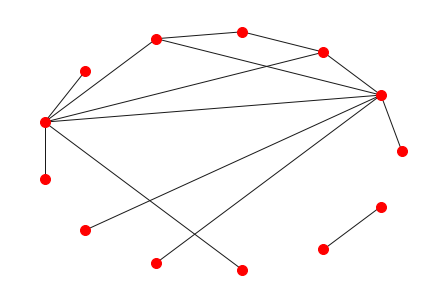

In [ ]:
#Network graph
G = nx.from_pandas_edgelist(rules_relevant, 'antecedents', 'consequents')
nx.draw(G, node_size=100, node_color="red", pos=nx.circular_layout(G))
plt.savefig('network.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0)

## Identify insights

In [ ]:
#Vengono estratti gli articoli dagli itemsets
antecedents = []
for i in range(len(rules_relevant)):
  antecedents = antecedents + list(rules_relevant['antecedents'][i])
antecedents = list(dict.fromkeys(antecedents))

consequents = []
for i in range(len(rules_relevant)):
  consequents = consequents + list(rules_relevant['consequents'][i])
consequents = list(dict.fromkeys(consequents))

#Gli articoli degli itemsets vengono uniti in un'unica lista
articles = antecedents + consequents
articles = list(dict.fromkeys(articles))

In [ ]:
#Viene creato un dataframe con solo le righe corrispondenti agli articoli estratti dagli itemsets
interesting_articles = df7_mba[df7_mba['ID_ARTICOLO'].isin(articles)]
interesting_articles.reset_index(inplace = True, drop = True)
interesting_articles

,ID_SCONTRINO,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DATETIME,ORA,DATA,IMPORTO_NETTO
0,513214723319/02/191028223327091,46747,20,36298122,3,2019-02-19 10:28:22,10,2019-02-19,12.4
1,513123649819/02/191146089082367,606663,21,36298122,3,2019-02-19 11:46:08,11,2019-02-19,12.4
2,513123649819/02/191146089082367,606663,21,36298353,3,2019-02-19 11:46:08,11,2019-02-19,19.9
3,513123649819/02/191146089082367,606663,21,36298381,3,2019-02-19 11:46:08,11,2019-02-19,19.9
4,513123649819/02/191146089082367,606663,21,36298416,3,2019-02-19 11:46:08,11,2019-02-19,19.9
...,...,...,...,...,...,...,...,...,...
2431,513229444429/04/191416029745001,909921,20,36298381,3,2019-04-29 14:16:02,14,2019-04-29,18.9
2432,513229444429/04/191416029745001,909921,20,36298381,3,2019-04-29 14:16:02,14,2019-04-29,18.9
2433,513229444429/04/191416029745001,909921,20,36298381,3,2019-04-29 14:16:02,14,2019-04-29,18.9
2434,513229444429/04/191416029745001,909921,20,36298381,3,2019-04-29 14:16:02,14,2019-04-29,18.9


In [ ]:
interesting_articles[interesting_articles['COD_REPARTO'] != 3]
#Tutti i prodotti appartengono al reparto 3

,ID_SCONTRINO,ID_CLI,ID_NEG,ID_ARTICOLO,COD_REPARTO,DATETIME,ORA,DATA,IMPORTO_NETTO


In [ ]:
#Si crea un dataset con gli articoli estratti, l'importo medio di acquisto, quante volte è stato acquistato e il numero di clienti che lo ha
#acquistato
interesting_articles_prices = interesting_articles.groupby('ID_ARTICOLO', as_index = False).agg(IMPORTO_MEDIO = ('IMPORTO_NETTO', 'mean'), NUMERO_ACQUISTI = ('ID_SCONTRINO', 'nunique'), NUMERO_CLIENTI = ('ID_CLI', 'nunique'))
interesting_articles_prices

,ID_ARTICOLO,IMPORTO_MEDIO,NUMERO_ACQUISTI,NUMERO_CLIENTI
0,36298122,15.864334,497,455
1,36298206,15.108919,346,324
2,36298353,24.190000,526,488
3,36298381,24.085966,458,431
4,36298395,24.625036,280,267
5,36298416,22.010069,284,272


In [ ]:
#Il prodotto scelto è 36298353 perché è quello acquistato più volte
consequents_products = []
for i in range(len(rules_relevant)):
  if 36298353 in rules_relevant['antecedents'][i]:
    consequents_products = consequents_products + list(rules_relevant['consequents'][i])
consequents_products = list(dict.fromkeys(consequents_products))

antecedents_products = []
for i in range(len(rules_relevant)):
  if 36298353 in rules_relevant['consequents'][i]:
    antecedents_products.append(list(rules_relevant['antecedents'][i]))

print("I prodotti che influenzano l'articolo 36298353 sono:")
print(*antecedents_products, sep = ', ')
print("I prodotti influenzati dall'articolo 36298353 sono:")
print(*consequents_products, sep = ', ')

I prodotti che influenzano l'articolo 36298353 sono:
[36298395], [36298416], [36298416, 36298381], [36298395, 36298381], [36298122, 36298381], [36298395], [36298416], [36298381]
I prodotti influenzati dall'articolo 36298353 sono:
36298381


In [ ]:
#Si crea un dataset con tutte le varie associazioni e il guadagno
ANTECEDENTS = []
for i in range(len(rules_relevant)):
  ANTECEDENTS.append(list(rules_relevant['antecedents'][i]))

CONSEQUENTS = []
for i in range(len(rules_relevant)):
  CONSEQUENTS.append(list(rules_relevant['consequents'][i]))

IMPORTO_MEDIO_ANTECEDENTS = []
for i in range(len(rules_relevant)):
  importo = 0
  for k in range(len(interesting_articles_prices)):
    if interesting_articles_prices['ID_ARTICOLO'][k] in rules_relevant['antecedents'][i]:
      importo = interesting_articles_prices['IMPORTO_MEDIO'][k] + importo
  IMPORTO_MEDIO_ANTECEDENTS.append(importo)

IMPORTO_MEDIO_CONSEQUENTS = []
for i in range(len(rules_relevant)):
  importo = 0
  for k in range(len(interesting_articles_prices)):
    if interesting_articles_prices['ID_ARTICOLO'][k] in rules_relevant['consequents'][i]:
      importo = interesting_articles_prices['IMPORTO_MEDIO'][k] + importo
  IMPORTO_MEDIO_CONSEQUENTS.append(importo)

NOME = ['itemset1', 'itemset2', 'itemset3', 'itemset4', 'itemset5', 'itemset6', 'itemset7', 'itemset8', 'itemset9', 'itemset10', 'itemset11', 'itemset12', 'itemset13', 'itemset14', 'itemset15']

df = {'NOME': NOME, 'ANTECEDENTS' : ANTECEDENTS, 'CONSEQUENTS' : CONSEQUENTS, 'IMPORTO_MEDIO_ANTECEDENTS' : IMPORTO_MEDIO_ANTECEDENTS, 'IMPORTO_MEDIO_CONSEQUENTS' : IMPORTO_MEDIO_CONSEQUENTS}
df = pd.DataFrame(data = df)
df['IMPORTO_MEDIO_TOTALE'] = df['IMPORTO_MEDIO_ANTECEDENTS'] + df['IMPORTO_MEDIO_CONSEQUENTS']

In [ ]:
df

,NOME,ANTECEDENTS,CONSEQUENTS,IMPORTO_MEDIO_ANTECEDENTS,IMPORTO_MEDIO_CONSEQUENTS,IMPORTO_MEDIO_TOTALE
0,itemset1,"[36298353, 36298122]",[36298381],40.054334,24.085966,64.140300
1,itemset2,[36298395],"[36298353, 36298381]",24.625036,48.275966,72.901001
2,itemset3,[36298416],"[36298353, 36298381]",22.010069,48.275966,70.286035
3,itemset4,"[36298416, 36298381]",[36298353],46.096035,24.190000,70.286035
4,itemset5,"[36298395, 36298381]",[36298353],48.711001,24.190000,72.901001
5,itemset6,"[36298353, 36298395]",[36298381],48.815036,24.085966,72.901001
6,itemset7,"[36298416, 36298353]",[36298381],46.200069,24.085966,70.286035
7,itemset8,"[36298122, 36298381]",[36298353],39.950300,24.190000,64.140300
8,itemset9,[36298206],[36298122],15.108919,15.864334,30.973253
9,itemset10,[36298395],[36298353],24.625036,24.190000,48.815036


In [ ]:
#Per la prima associazione (quella con lift maggiore) si calcola la differenza dei giorni tra un acquisto e l'altro per fare delle offerte
#personalizzate
best_association = interesting_articles[(interesting_articles['ID_ARTICOLO'] == 36298353) | (interesting_articles['ID_ARTICOLO'] == 36298122) | (interesting_articles['ID_ARTICOLO'] == 36298381)]
best_association.reset_index(inplace = True, drop = True)
tickets = best_association.groupby('ID_SCONTRINO')[['ID_ARTICOLO']].nunique()
tickets.reset_index(inplace = True)
tickets.rename(columns = {'ID_ARTICOLO' : 'NUMERO_ARTICOLI'}, inplace = True)
tickets.drop(tickets.index[tickets['NUMERO_ARTICOLI'] < 3], inplace = True)
best_association = best_association.merge(tickets, on = 'ID_SCONTRINO', how = 'left')
best_association.dropna(subset = ['NUMERO_ARTICOLI'], inplace = True)
best_association.sort_values(by = 'DATA', inplace = True)
best_association.reset_index(inplace = True, drop = True)
best_day = best_association.groupby('ID_CLI', as_index = False).agg(PRIMO_ACQUISTO = ('DATA', 'min'), 
                                                                    ULTIMO_ACQUISTO = ('DATA', 'max'), NUMERO_ACQUISTI = ('DATA', 'nunique'))
day = best_association.groupby(['ID_CLI', 'DATA']).agg(PRIMO_ACQUISTO = ('DATA', 'min'))
day.reset_index(inplace = True)
day.drop(['PRIMO_ACQUISTO'], axis = 1, inplace = True)
day = day.groupby('ID_CLI')[['DATA']].nth(-2)
day.reset_index(inplace = True)
day.rename(columns = {'DATA' : 'PENULTIMO_ACQUISTO'}, inplace = True)
best_day = pd.merge(best_day, day, on = 'ID_CLI', how = 'left')
best_day['NEXT_PURCHASE_DAY'] = (best_day['ULTIMO_ACQUISTO'] - best_day['PENULTIMO_ACQUISTO']).dt.days
best_day['NEXT_PURCHASE_DAY'] = best_day['NEXT_PURCHASE_DAY'].fillna(0)
best_day.drop(best_day.index[best_day['NUMERO_ACQUISTI'] == 1], inplace = True)
best_day.reset_index(inplace = True, drop = True)
best_day

,ID_CLI,PRIMO_ACQUISTO,ULTIMO_ACQUISTO,NUMERO_ACQUISTI,PENULTIMO_ACQUISTO,NEXT_PURCHASE_DAY
0,99384,2019-04-11,2019-04-25,2,2019-04-11,14.0
1,146194,2019-04-10,2019-04-24,2,2019-04-10,14.0
2,268256,2019-03-22,2019-04-10,2,2019-03-22,19.0
3,295306,2019-03-22,2019-04-12,2,2019-03-22,21.0
4,427440,2019-04-01,2019-04-11,2,2019-04-01,10.0
5,687151,2019-03-11,2019-04-02,2,2019-03-11,22.0
6,773756,2019-03-22,2019-04-10,2,2019-03-22,19.0
7,799817,2019-03-03,2019-03-29,2,2019-03-03,26.0
8,853048,2019-03-07,2019-03-25,2,2019-03-07,18.0
9,907665,2019-04-11,2019-04-23,2,2019-04-11,12.0


In [ ]:
print(f"In media la prima associazione viene acquistata ogni {best_day['NEXT_PURCHASE_DAY'].mean()} giorni")

In media la prima associazione viene acquistata ogni 17.5 giorni
